<a href="https://colab.research.google.com/github/programminghumanity/iphs200fall2020/blob/main/twitter_step5_topic_models_pyLDAvis_20201210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling Tweets and Visualizing with pyLDAvis**

References:

* https://medium.com/datadriveninvestor/trump-tweets-topic-modeling-using-latent-dirichlet-allocation-e4f93b90b6fe

# **0. Setup and Configuration**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd ./MyDrive/courses/2020f_iphs200_programming_humanity/code/twint/

/gdrive/MyDrive/courses/2020f_iphs200_programming_humanity/code/twint


In [ ]:
!ls -al tweets_plaintext_rev_*.txt

-rw------- 1 root root 148263 Dec  8 23:37 tweets_plaintext_rev_20201208-233326.txt
-rw------- 1 root root 148263 Dec  9 19:37 tweets_plaintext_rev_20201209-193707.txt
-rw------- 1 root root 151445 Dec  9 19:42 tweets_plaintext_rev_periods_20201209-193707.txt
-rw------- 1 root root 149853 Dec  9 20:00 tweets_plaintext_rev_sent_20201209-193707.txt


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [ ]:
imUsingColab = True

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair

     |████████████████████████████████| 1.6MB 5.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=a8320478646a1f9389872828c62338d747a9682ce0da90d08e35983f66944284
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
     |████████████████████████████████| 1.3MB 5.7MB/s 


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
import re
import string

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
pd.options.mode.chained_assignment = None 

random_state = 20181126

# **1. Load and Clean Preprocessed Tweets**

The tweets have already been cleaned and stored in a plaintext *.txt file with one tweet per line. Each tweet has been turned into a pseudo-sentence with an initial Capital letter and and ending period.

In [ ]:
!pwd

/gdrive/My Drive/courses/2020f_iphs200_programming_humanity/code/twint


In [ ]:
!ls -al tweets_plaintext_rev_*.txt

-rw------- 1 root root 148263 Dec  8 23:37 tweets_plaintext_rev_20201208-233326.txt
-rw------- 1 root root 148263 Dec  9 19:37 tweets_plaintext_rev_20201209-193707.txt
-rw------- 1 root root 151445 Dec  9 19:42 tweets_plaintext_rev_periods_20201209-193707.txt
-rw------- 1 root root 149853 Dec  9 20:00 tweets_plaintext_rev_sent_20201209-193707.txt


In [ ]:
tweets_df = pd.read_csv('tweets_plaintext_rev_sent_20201209-193707.txt', header=None, names=['text'])
tweets_df.head()

,text
0,Hacked my tesla charge connector on a small is...
1,The exec conf room at tesla used to be called ...
2,A tesla roadster just passed the mile mark for...
3,Will communicate better in the future too many...
4,That is not just paranoia a healthy trait at t...


In [ ]:
tweets_df = tweets_df.convert_dtypes()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1591 non-null   string
dtypes: string(1)
memory usage: 12.6 KB


In [ ]:
def clean_text(text):
  ''', , and '''
  #Make text lowercase   
  text = text.lower()
  #remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  #remove punctuation   
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) 
  #remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)

  return text


In [ ]:
tweets_df['clean'] = tweets_df['text'].apply(lambda x: clean_text(x))
# pd.DataFrame(tweets_df.content.apply(lambda x: clean_text(x)))
tweets_df.head()

,text,clean
0,Hacked my tesla charge connector on a small is...,hacked my tesla charge connector on a small is...
1,The exec conf room at tesla used to be called ...,the exec conf room at tesla used to be called ...
2,A tesla roadster just passed the mile mark for...,a tesla roadster just passed the mile mark for...
3,Will communicate better in the future too many...,will communicate better in the future too many...
4,That is not just paranoia a healthy trait at t...,that is not just paranoia a healthy trait at t...


In [ ]:
tweets_df.iloc[0]['clean']

'hacked my tesla charge connector on a small island in the rain last night'

In [ ]:
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [ ]:
tweets_df['clean'] = tweets_df['clean'].apply(lambda x: lemmatizer(x))
# pd.DataFrame(tweets_df_clean.content.apply(lambda x: lemmatizer(x)))
tweets_df['clean'] = tweets_df['clean'].str.replace('-PRON-', '')
tweets_df.head()

,text,clean
0,Hacked my tesla charge connector on a small is...,hack tesla charge connector on a small island...
1,The exec conf room at tesla used to be called ...,the exec conf room at tesla use to be call den...
2,A tesla roadster just passed the mile mark for...,a tesla roadster just pass the mile mark for t...
3,Will communicate better in the future too many...,will communicate better in the future too many...
4,That is not just paranoia a healthy trait at t...,that be not just paranoia a healthy trait at t...


In [ ]:
tweets_df.iloc[0]['clean']

'hack  tesla charge connector on a small island in the rain last night'

# **2. EDA Visualizations**

### Tweet length

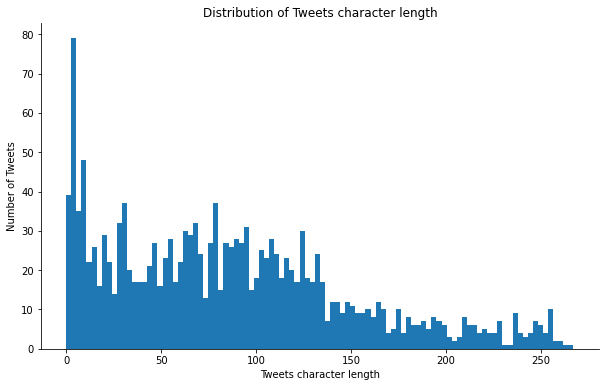

In [ ]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df.clean]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

### WordCloud

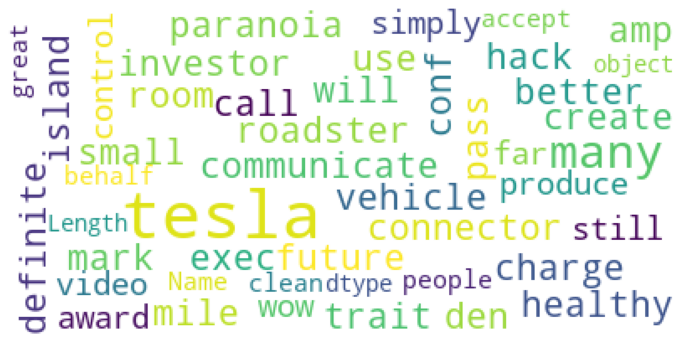

In [ ]:
mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
  background_color='white',
  stopwords=stopwords,
  max_words=500,
  max_font_size=40, 
  random_state=100
  ).generate(str(tweets_df.clean))
print(wordcloud)

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### Unigrams

In [ ]:
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]


In [ ]:
common_words = get_top_n_words(tweets_df.clean, 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

unigram.head(10)

,unigram,count
0,tesla,1033
1,amp,426
2,car,219
3,model,112
4,year,111
5,make,107
6,work,103
7,just,94
8,good,88
9,team,84


### Bigrams

In [ ]:
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2,2),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [ ]:
common_words = get_top_n_trigram(tweets_df.clean, 10)
bigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

bigram.head(10)

,trigram,count
0,tesla model,36
1,tesla team,33
2,tesla owner,32
3,come soon,27
4,tesla amp,23
5,amp tesla,21
6,tesla car,20
7,tesla solar,19
8,tesla autopilot,16
9,thank tesla,16


### Trigrams

In [ ]:
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [ ]:
common_words = get_top_n_trigram(tweets_df.clean, 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

trigram.head(10)

,trigram,count
0,tesla china team,8
1,tesla self driving,8
2,spacex amp tesla,7
3,tesla amp spacex,7
4,self driving option,7
5,proud tesla team,5
6,tesla supercharg network,5
7,tesla service center,5
8,tesla phone app,5
9,tesla fsd computer,5


# **3. Topic Modeling with LDA**

In [ ]:
vectorizer = CountVectorizer(
  analyzer='word',       
  min_df=3,# minimum required occurences of a word 
  stop_words='english',# remove stop words
  lowercase=True,# convert all words to lowercase
  token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
  max_features=5000,# max number of unique words
)
data_matrix = vectorizer.fit_transform(tweets_df.clean)

data_matrix

<1591x997 sparse matrix of type '<class 'numpy.int64'>'
	with 10926 stored elements in Compressed Sparse Row format>

In [ ]:
lda_model = LatentDirichletAllocation(
  n_components=10, # Number of topics
  learning_method='online',
  random_state=20,       
  n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

### Visualization with pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  22.213289
5       0.648955  71.707100       2        1  13.946375
1      71.019684   9.971006       3        1  12.248192
7       3.785981  33.185135       4        1  12.198037
2     -42.666500  -9.222070       5        1   9.793464
0      -3.621689 -43.526516       6        1   7.794475
3      -3.632402  -4.171708       7        1   6.826790
9     -36.584400  35.804413       8        1   5.550422
4      44.391380  50.615383       9        1   5.033878
6      40.235809 -31.591665      10        1   4.395079, topic_info=       Term        Freq       Total Category  logprob  loglift
35      amp  397.000000  397.000000  Default  30.0000  30.0000
991    year   98.000000   98.000000  Default  29.0000  29.0000
981    work   97.000000   97.000000  Default  28.0000  28.0000
376    good   78.000000   78.000000  Default  27.0000  27.0000
992     yes   60.000000   60.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
688  public    5.063058   12.070329  Topic10  -4.6036   2.2559
106   build    6.433059   32.058651  Topic10  -4.3641   1.5186
56     auto    5.526463   20.078274  Topic10  -4.5160   1.8346
948   value    5.461555   19.510424  Topic10  -4.5279   1.8515
514    long    5.009216   19.907466  Topic10  -4.6143   1.7449

[519 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3         4  0.959001  absolutely
4         7  0.890255  accelerate
6         3  0.947433      access
7         5  0.868704    accident
11        4  0.872782     achieve
...     ...       ...         ...
991       2  0.922072        year
991       6  0.060796        year
992       4  0.977283         yes
994       4  0.787716        york
995       7  0.930236        zero

[727 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 2, 8, 3, 1, 4, 10, 5, 7])

### Top 10 Words for Every Topic

In [ ]:
for i,topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:
['post', 'online', 'model', 'car', 'world', 'day', 'order', 'price', 'week', 'tesla']


Top 10 words for topic #1:
['fun', 'buy', 'new', 'product', 'fsd', 'come', 'owner', 'soon', 'car', 'tesla']


Top 10 words for topic #2:
['self', 'version', 'improve', 'release', 'autopilot', 'motor', 'sure', 'software', 'amp', 'tesla']


Top 10 words for topic #3:
['zero', 'mile', 'range', 'lot', 'credit', 'net', 'roof', 'time', 'solar', 'tesla']


Top 10 words for topic #4:
['supercharg', 'sound', 'yeah', 'point', 'use', 'haha', 'probably', 'like', 'good', 'tesla']


Top 10 words for topic #5:
['production', 'exactly', 'maybe', 'company', 'high', 'model', 'car', 'amp', 'year', 'tesla']


Top 10 words for topic #6:
['board', 'complete', 'machine', 'testing', 'sorry', 'sustainable', 'high', 'definitely', 'safety', 'work']


Top 10 words for topic #7:
['vehicle', 'fast', 'free', 'electric', 'service', 'amp', 'make', 'car', 'yes', 'tesla']


Top 10 words for topic #8:
['appr

In [ ]:
topic_values = lda_model.transform(data_matrix)
tweets_df['Topic'] = topic_values.argmax(axis=1)

In [ ]:
tweets_df.head()

,text,clean,Topic
0,Hacked my tesla charge connector on a small is...,hack tesla charge connector on a small island...,8
1,The exec conf room at tesla used to be called ...,the exec conf room at tesla use to be call den...,8
2,A tesla roadster just passed the mile mark for...,a tesla roadster just pass the mile mark for t...,3
3,Will communicate better in the future too many...,will communicate better in the future too many...,5
4,That is not just paranoia a healthy trait at t...,that be not just paranoia a healthy trait at t...,8
